In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

Total anomalies detected: 50


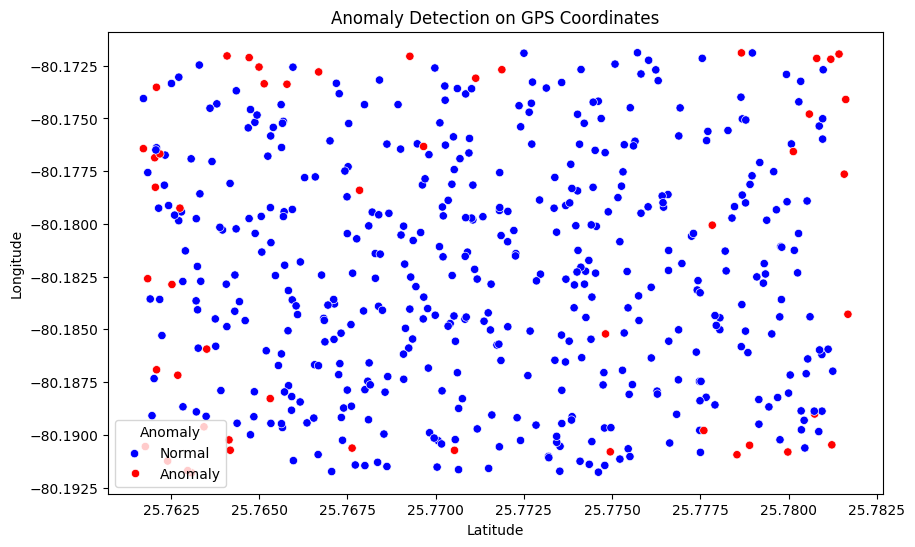

              File        Date Created       Date Modified  File Size (KB)  \
26    image_27.jpg 2023-01-01 11:18:04 2023-01-01 11:19:04            4004   
27    image_28.jpg 2023-01-01 16:54:10 2023-01-01 17:54:10            1420   
31    image_32.jpg 2023-01-01 17:52:44 2023-01-01 17:59:44            4042   
37    image_38.jpg 2023-01-01 12:56:01 2023-01-01 13:44:01            1149   
44    image_45.jpg 2023-01-01 15:45:32 2023-01-01 15:46:32            7898   
57    image_58.jpg 2023-01-01 13:24:18 2023-01-01 14:10:18            1522   
60    image_61.jpg 2023-01-01 17:49:29 2023-01-01 18:20:29            1120   
77    image_78.jpg 2023-01-01 12:40:47 2023-01-01 13:35:47            7866   
81    image_82.jpg 2023-01-01 14:21:06 2023-01-01 15:05:06            1261   
87    image_88.jpg 2023-01-01 14:10:01 2023-01-01 14:25:01            7964   
123  image_124.jpg 2023-01-01 16:44:36 2023-01-01 16:49:36            1307   
124  image_125.jpg 2023-01-01 14:58:54 2023-01-01 15:57:54      

In [21]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

# Load the EXIF data from the file path
file_path = "/content/drive/MyDrive/large_dummy_exif_data_crime_scene.csv"
exif_data = pd.read_csv(file_path)

# Preprocess the data
# Convert 'Date Created' and 'Date Modified' to datetime for consistency
exif_data['Date Created'] = pd.to_datetime(exif_data['Date Created'], errors='coerce')
exif_data['Date Modified'] = pd.to_datetime(exif_data['Date Modified'], errors='coerce')

# Extract useful features for anomaly detection
# Compute time difference between creation and modification
exif_data['Time Difference (Days)'] = (exif_data['Date Created'] - exif_data['Date Modified']).dt.total_seconds() / 86400

# Normalize numerical features
exif_data['File Size (KB)'] = exif_data['File Size (KB)']

# Use the correct column names for latitude and longitude
exif_data['Latitude'] = exif_data['Latitude']
exif_data['Longitude'] = exif_data['Longitude']

# Prepare features for the model
# Corrected to use 'File Size (KB)' instead of 'File Size (MB)'
features = exif_data[['Time Difference (Days)', 'File Size (KB)', 'Latitude', 'Longitude']].fillna(0)

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)  # Adjust contamination as needed

# Fit the model and predict anomalies
exif_data['Anomaly'] = model.fit_predict(features)

# Extract anomalies and normal data
anomalies = exif_data[exif_data['Anomaly'] == -1]
normal_data = exif_data[exif_data['Anomaly'] == 1]

# Print total number of anomalies detected
print(f"Total anomalies detected: {len(anomalies)}")

# Visualize anomalies based on GPS coordinates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=exif_data, x='Latitude', y='Longitude', hue='Anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomaly Detection on GPS Coordinates')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()

# Display detailed information of detected anomalies
anomalies_details = anomalies[['File', 'Date Created', 'Date Modified', 'File Size (KB)', 'Latitude', 'Longitude', 'Device']]
print(anomalies_details)




In [25]:
import folium

# Create a map centered around the average latitude and longitude of the anomalies
m = folium.Map(location=[anomalies['Latitude'].mean(), anomalies['Longitude'].mean()], zoom_start=13)

# Add markers for anomalous GPS locations
for index, row in anomalies.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']],
                  popup=f"File: {row['File']}").add_to(m)

# Save the map to an HTML file
m.save("anomaly_map1.html")


In [26]:
from google.colab import files
files.download('anomaly_map1.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

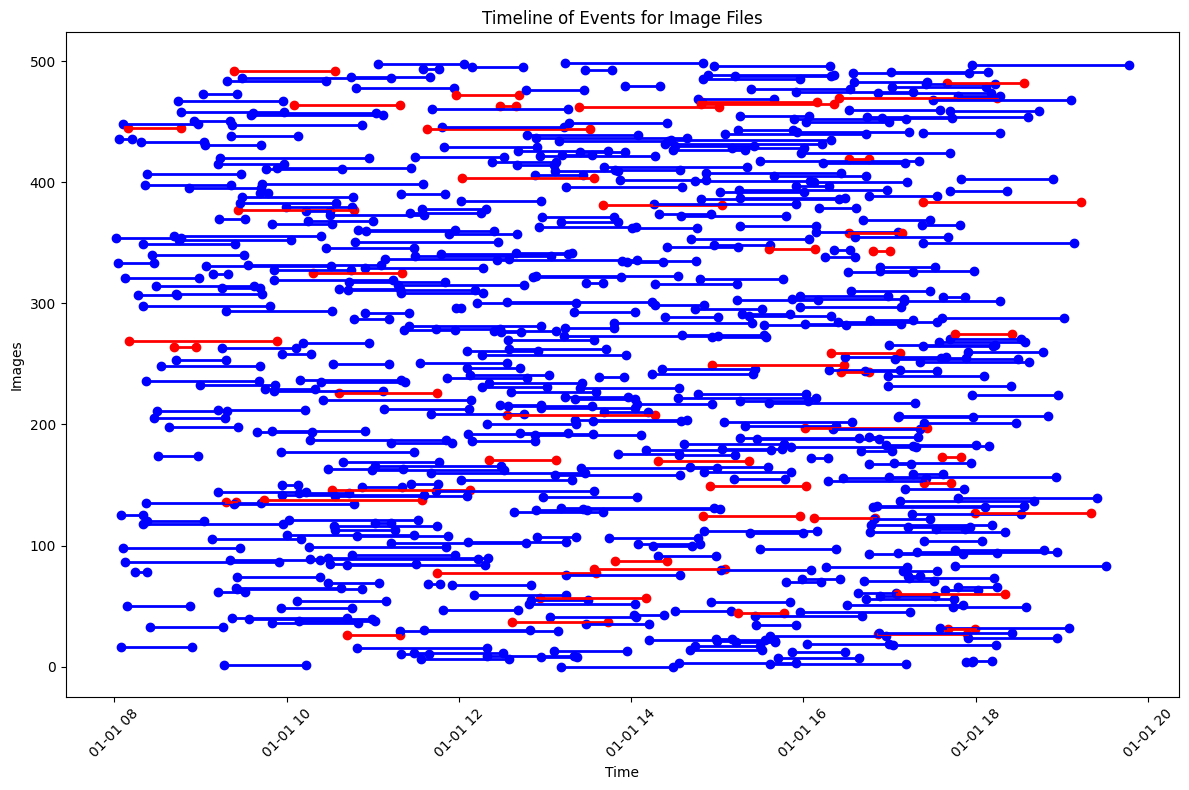

In [28]:
# Sort the data by 'Date Shot' for chronological analysis
timeline_data = exif_data[['File', 'Date Shot', 'Date Created', 'Date Modified', 'Anomaly']].sort_values('Date Shot')

# Convert timestamps to datetime format that matplotlib can handle
timeline_data['Date Shot'] = pd.to_datetime(timeline_data['Date Shot'])
timeline_data['Date Modified'] = pd.to_datetime(timeline_data['Date Modified'])

# Plot a Gantt-like chart to visualize the timeline of events
plt.figure(figsize=(12, 8))

# Loop through each row to plot the time intervals for 'Date Shot' to 'Date Modified'
for index, row in timeline_data.iterrows():
    if pd.notna(row['Date Shot']) and pd.notna(row['Date Modified']):
        # Use red for anomalies and blue for normal
        color = 'red' if row['Anomaly'] == -1 else 'blue'
        plt.plot([row['Date Shot'], row['Date Modified']], [index, index], color=color, linewidth=2)
        # Highlight the start and end points
        plt.scatter([row['Date Shot'], row['Date Modified']], [index, index], color=color)

plt.title('Timeline of Events for Image Files')
plt.xlabel('Time')
plt.ylabel('Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [29]:
import plotly.express as px

# Create a new DataFrame for Gantt-like visualization
gantt_data = timeline_data[['File', 'Date Shot', 'Date Modified', 'Anomaly']].dropna()

# Create a Gantt chart using Plotly Express
fig = px.timeline(
    gantt_data,
    x_start='Date Shot',
    x_end='Date Modified',
    y='File',
    color='Anomaly',
    color_discrete_map={-1: 'red', 1: 'blue'},
    title="Timeline of Events for Image Files (Gantt Chart)"
)

fig.update_yaxes(categoryorder='total ascending')
fig.update_layout(xaxis_title='Time', yaxis_title='Images', height=800)
fig.show()


In [30]:
import plotly.graph_objects as go

# Create scatter plot with hover information
fig = go.Figure()

# Plot normal data points in blue
fig.add_trace(go.Scatter(
    x=timeline_data['Date Shot'],
    y=timeline_data.index,
    mode='markers',
    marker=dict(color='blue'),
    name='Normal',
    hoverinfo='text',
    text=[f"File: {file}, Date Shot: {date}" for file, date in zip(timeline_data['File'], timeline_data['Date Shot'])]
))

# Plot anomalous data points in red
anomalies = timeline_data[timeline_data['Anomaly'] == -1]
fig.add_trace(go.Scatter(
    x=anomalies['Date Shot'],
    y=anomalies.index,
    mode='markers',
    marker=dict(color='red'),
    name='Anomaly',
    hoverinfo='text',
    text=[f"File: {file}, Date Shot: {date}" for file, date in zip(anomalies['File'], anomalies['Date Shot'])]
))

fig.update_layout(
    title="Timeline of Events for Image Files (Interactive Scatter Plot)",
    xaxis_title='Date Shot',
    yaxis_title='Image Index',
    height=600
)
fig.show()


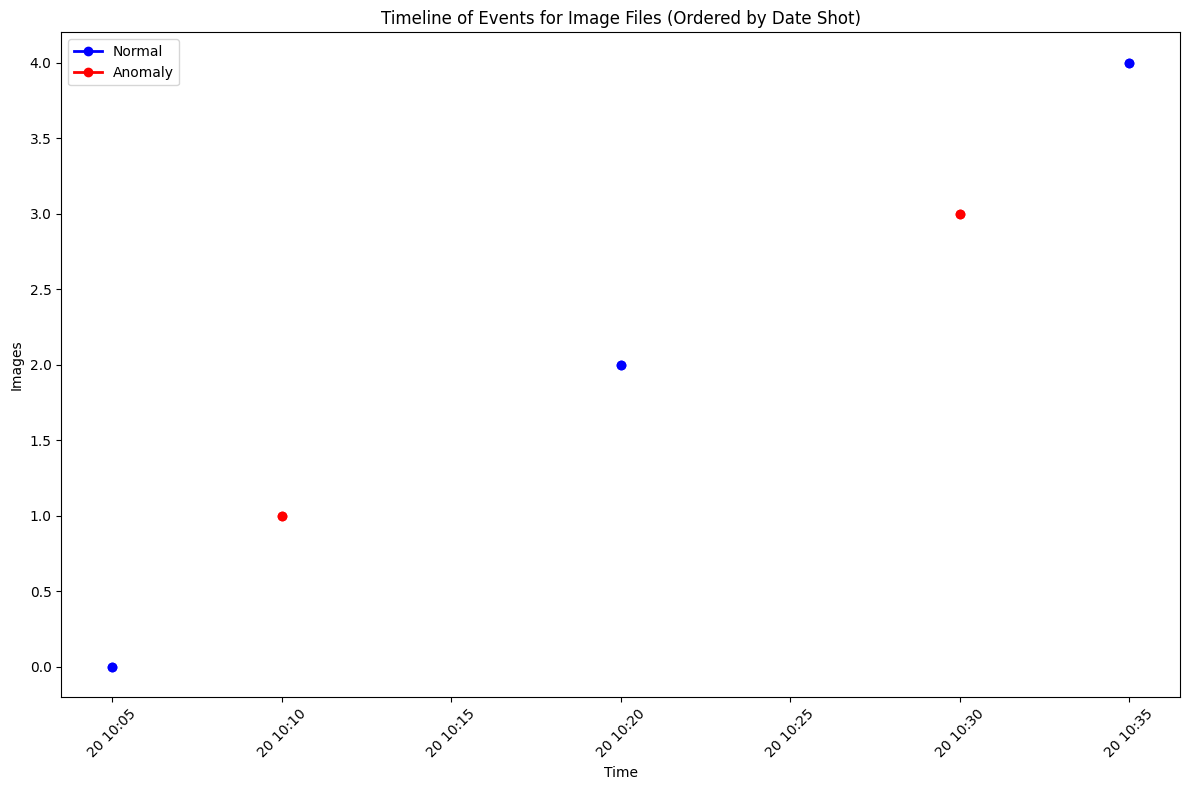

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Dummy dataset for illustration
data = {
    'File': ['image_27.jpg', 'image_28.jpg', 'image_32.jpg', 'image_38.jpg', 'image_45.jpg'],
    'Date Shot': pd.to_datetime(['2024-10-20 10:05:00', '2024-10-20 10:10:00', '2024-10-20 10:20:00', '2024-10-20 10:30:00', '2024-10-20 10:35:00']),
    'Latitude': [25.77998, 25.777839, 25.763082, 25.765141, 25.774814],
    'Longitude': [-80.190814, -80.180058, -80.191797, -80.173354, -80.185215],
    'Anomaly': [1, -1, 1, -1, 1]  # 1: Normal, -1: Anomaly
}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by 'Date Shot'
df = df.sort_values(by='Date Shot')

# Plotting the timeline
plt.figure(figsize=(12, 8))

# Loop through each row to plot the time intervals for each image
for index, row in df.iterrows():
    # Use red for anomalies and blue for normal
    color = 'red' if row['Anomaly'] == -1 else 'blue'

    # Plotting timeline as a horizontal line representing the time
    plt.plot([row['Date Shot'], row['Date Shot']], [index, index], marker='o', color=color, linewidth=2, label=row['File'] if index == 0 else "")

# Adding labels to the chart
plt.title('Timeline of Events for Image Files (Ordered by Date Shot)')
plt.xlabel('Time')
plt.ylabel('Images')
plt.xticks(rotation=45)

# Adding legend to indicate normal vs anomaly
plt.legend(['Normal', 'Anomaly'], loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


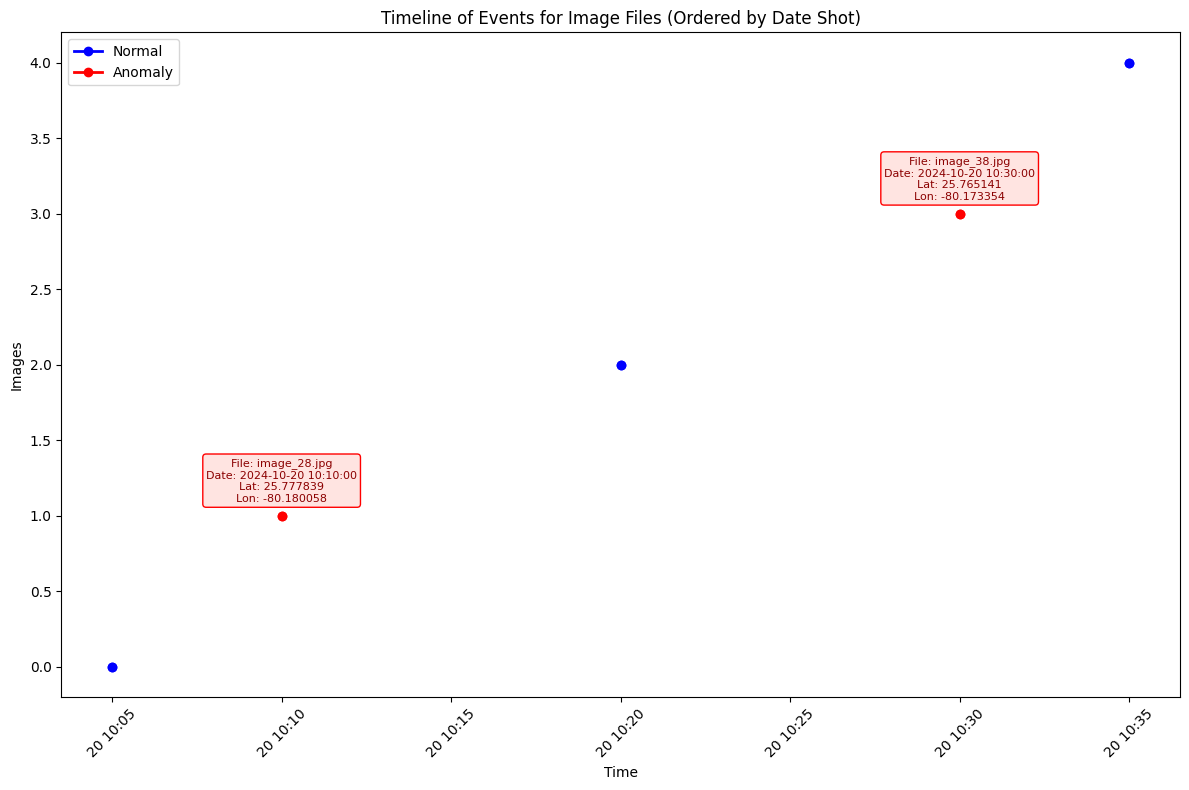

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Dummy dataset for illustration
data = {
    'File': ['image_27.jpg', 'image_28.jpg', 'image_32.jpg', 'image_38.jpg', 'image_45.jpg'],
    'Date Shot': pd.to_datetime(['2024-10-20 10:05:00', '2024-10-20 10:10:00', '2024-10-20 10:20:00', '2024-10-20 10:30:00', '2024-10-20 10:35:00']),
    'Latitude': [25.77998, 25.777839, 25.763082, 25.765141, 25.774814],
    'Longitude': [-80.190814, -80.180058, -80.191797, -80.173354, -80.185215],
    'Anomaly': [1, -1, 1, -1, 1]  # 1: Normal, -1: Anomaly
}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by 'Date Shot'
df = df.sort_values(by='Date Shot')

# Plotting the timeline
plt.figure(figsize=(12, 8))

# Loop through each row to plot the time intervals for each image
for index, row in df.iterrows():
    # Use red for anomalies and blue for normal
    color = 'red' if row['Anomaly'] == -1 else 'blue'

    # Plotting timeline as a horizontal line representing the time
    plt.plot([row['Date Shot'], row['Date Shot']], [index, index], marker='o', color=color, linewidth=2)

    # Annotate anomalies with detailed descriptions
    if row['Anomaly'] == -1:
        plt.annotate(
            f"File: {row['File']}\nDate: {row['Date Shot']}\nLat: {row['Latitude']}\nLon: {row['Longitude']}",
            (row['Date Shot'], index),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            fontsize=8,
            color='darkred',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='mistyrose')
        )

# Adding labels to the chart
plt.title('Timeline of Events for Image Files (Ordered by Date Shot)')
plt.xlabel('Time')
plt.ylabel('Images')
plt.xticks(rotation=45)

# Adding legend to indicate normal vs anomaly
plt.legend(['Normal', 'Anomaly'], loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
